In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

### Method 1: Standard Deviation

In statistics, If a data distribution is approximately normal then about 68% of the data values lie within one standard deviation of the mean and about 95% are within two standard deviations, and about 99.7% lie within three standard deviations.

![](pic/normal_dist.png)

Therefore, if you have any data point that is more than 3 times the standard deviation, then those points are very likely to be anomalous or outliers.

lower limit and upper limit equals to -39.69 and 79.46


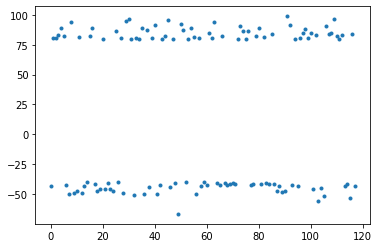

In [11]:
anomalies = []

# multiply and add by random numbers to get some real values
data = np.random.randn(50000)  * 20 + 20

# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(random_data):
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    print("lower limit and upper limit equals to",np.round(lower_limit,2),"and",np.round(upper_limit,2) )
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

anomalies=find_anomalies(data)
plt.plot(range(len(anomalies)),anomalies,".");

## Method 2: Boxplots

![](pic/boxplot.png)

Box plots are a graphical depiction of numerical data through their quantiles. It is a very simple but effective way to visualize outliers. Think about the lower and upper whiskers as the boundaries of the data distribution. Any data points that show above or below the whiskers, can be considered outliers or anomalous. Here is the code to plot a box plot:

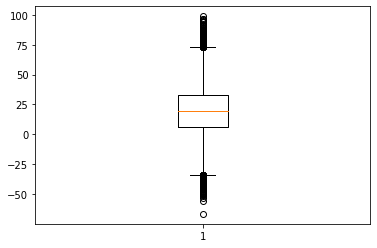

In [12]:
#sns.boxplot(data=data);
plt.boxplot(data);

The above code displays the plot below. As you can see, it considers everything above 75 or below ~ -35 to be an outlier. The results are very close to method 1 above.

### Boxplot Anatomy:

The concept of the Interquartile Range (IQR) is used to build the boxplot graphs. IQR is a concept in statistics that is used to measure the statistical dispersion and data variability by dividing the dataset into quartiles.
In simple words, any dataset or any set of observations is divided into four defined intervals based upon the values of the data and how they compare to the entire dataset. A quartile is what divides the data into three points and four intervals.

![](pic/IQ.png)

Interquartile Range (IQR) is important because it is used to define the outliers. It is the difference between the third quartile and the first quartile (IQR = Q3 -Q1). Outliers in this case are defined as the observations that are below (Q1 − 1.5x IQR) or boxplot lower whisker or above (Q3 + 1.5x IQR) or boxplot upper whisker.

![](pic/IQR.png)

## Method 3: Density-based techniques
### 3.1. Kernel density
#### 3.1.1. Kernel Density estimation based on Gaussian Kernel

In [15]:
from scipy.stats.kde import gaussian_kde
# Set sample parameters
np.random.seed(0)
n = 2010
d = 3

# Generate data
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)
print(X.shape)

(2010, 3)


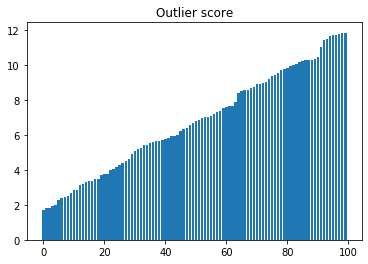

In [16]:
## dataset: Datapoints to estimate from. In case of univariate data this is a 1-D array, 
## otherwise a 2-D array with shape (# of dims, # of data).
kde = gaussian_kde(dataset=X.T)
scores = kde.evaluate(X.T)
idx = scores.argsort()
scores.sort()
# Plot kernel density estimate
plt.figure()
## the first 100, the lower value the higher probability of being outlier
plt.bar(range(100),scores[:100])
plt.title('Outlier score')
plt.show()

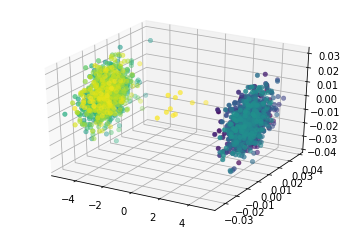

In [17]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=scores, cmap='viridis', linewidth=0.5);

#### 3.1.2. Kernel Density estimation based on KNN

In [18]:
from sklearn.neighbors import NearestNeighbors

# Find the k nearest neighbors
K=200
knn = NearestNeighbors(n_neighbors=K)
knn.fit(X)

# Compute the density
# Finds the K-neighbors of a point
D, i = knn.kneighbors(X)
knn_density = 1./(D.sum(axis=1)/K)

# Compute the average relative density
DX, iX = knn.kneighbors(X)
print(DX.shape)
knn_densityX = 1./(DX[:,1:].sum(axis=1)/K)
knn_avg_rel_density = knn_density/(knn_densityX[i[:,1:]].sum(axis=1)/K)

(2010, 200)


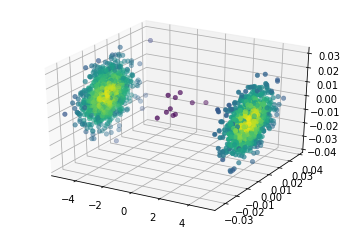

In [19]:
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=knn_density, cmap='viridis', linewidth=0.5);

### 3.2. DBScan Clustering:

DBScan is a clustering algorithm that’s used cluster data into groups. It is also used as a density-based anomaly detection method with either single or multi-dimensional data. Other clustering algorithms such as k-means and hierarchal clustering can also be used to detect outliers. DBScan has three important concepts:

**Core Points:** In order to understand the concept of the core points, we need to visit some of the hyperparameters used to define DBScan job. First hyperparameter (HP)is min_samples. This is simply the minimum number of core points needed in order to form a cluster. second important HP is eps. eps is the maximum distance between two samples for them to be considered as in the same cluster.

**Border Points** are in the same cluster as core points but much further away from the centre of the cluster.

Everything else is called **Noise Points**, those are data points that do not belong to any cluster. They can be anomalous or non-anomalous and they need further investigation. Now, let’s see some code.

![](pic/DBSCAN.png)

In [20]:
from sklearn.cluster import DBSCAN
np.random.seed(1)
random_data = np.random.randn(50000,2)  * 20 + 20

outlier_detection = DBSCAN(min_samples = 2, eps = 3)
clusters = outlier_detection.fit_predict(random_data)
list(clusters).count(-1)

94

The output of the above code is 94. This is the total number of noisy points. SKLearn labels the noisy points as (-1). The downside with this method is that the higher the dimension, the less accurate it becomes. You also need to make a few assumptions like estimating the right value for eps which can be challenging.

## Method 4— Isolation Forest
Isolation Forest is an unsupervised learning algorithm that belongs to the ensemble decision trees family. This approach is different from all previous methods. All the previous ones were trying to find the normal region of the data then identifies anything outside of this defined region to be an outlier or anomalous.

This method works differently. It explicitly isolates anomalies instead of profiling and constructing normal points and regions by assigning a score to each data point. It takes advantage of the fact that anomalies are the minority data points and that they have attribute-values that are very different from those of normal instances. This algorithm works great with very high dimensional datasets and it proved to be a very effective way of detecting anomalies. 

### Step 1 — Sampling for Training
- The very first step is sampling for training a model
- Depending on the underlying data set, a sampling proportion can be different (i.e. more noisy data -> higher sampling proportion can be preferable)

For the simplicity, I chose to use a 2-D visualization. You can think of Q1 and Q2 as two different attributes in your data set

![](pic/Q1Q2.png)

### Step 2 — Binary decision tree
- The following step essentially involves making a tree for the sample we drew from step 1
- This step involves two random elements: random choice of an attribute (i.e. Q1 or Q2) / random choice of a Q1 or Q2 value between its min and max (i.e. Q1’)

![](pic/s2.png)

### Step 3 — Repeat step 2 Iteratively
- Do step 2 for two sub-data set based on the binary split from step 2
- “Fewer and different” data points are isolated quicker such as the data point at the very lower right corner
- In other words, it takes less path for them to be isolated
- Do this iteratively to create a forest, a collection of trees

![](pic/s33.png)

### Step 4 — Feeding data set and calculating anomaly score
- Feed each data point into a trained forest model for each tree
- Anomaly score is defined as:

![](pic/eq.png)

- We calculate this anomaly score for each tree and average them out across different trees and get the final anomaly score for an entire forest for a given data point
- Mathematically, an outlier gets a score closer to 1. My empirical evidence also indicates that less number of trees means rather less closer (to 1) values for outlier

### Isolated forest example 

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [40]:
data = pd.read_csv('creditcard.csv')
print(data.shape)
data.head(10)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,'0'
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,'0'
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,'0'
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,'0'
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,'0'


The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset present transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are ‘Time’ and ‘Amount’. Feature ‘Time’ contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature ‘Amount’ is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature ‘Class’ is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [24]:
print(data.dtypes)
print()
print(data["Class"].value_counts())
##  using the regex \D to remove any non-digit characters
data['Class'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class      object
dtype: object

0    284315
1       492
Name: Class, dtype: int64


####  Histograms for the Time and Amount features

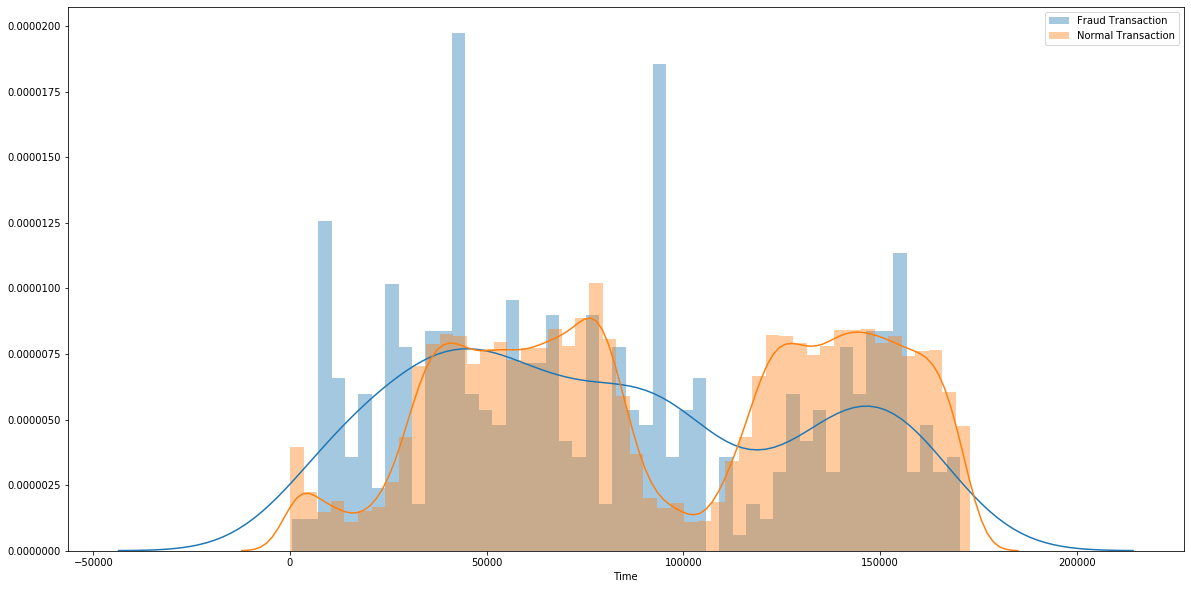

In [25]:
figure = plt.figure(figsize=(20,10))
sns.distplot(data[data['Class'] =="1"]['Time'],bins=50,kde=True,label ='Fraud Transaction')
sns.distplot(data[data['Class'] =="0"]['Time'],bins=50,kde=True,label = 'Normal Transaction')
plt.legend();

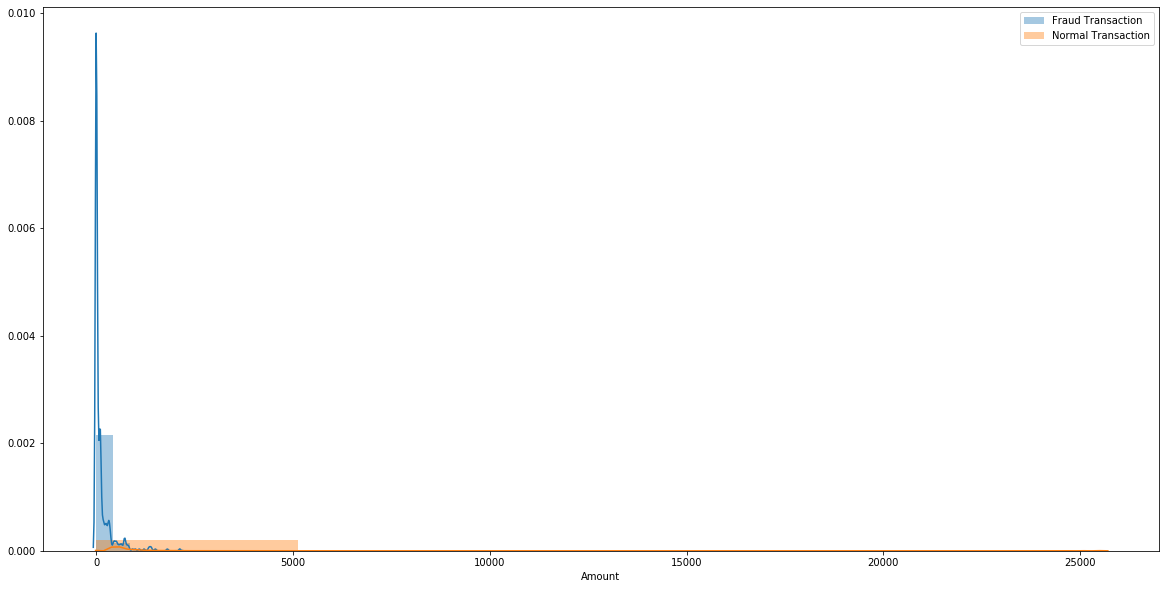

In [26]:
figure = plt.figure(figsize=(20,10))
sns.distplot(data[data['Class'] =="1"]['Amount'],bins=5,label ='Fraud Transaction')
sns.distplot(data[data['Class'] =="0"]['Amount'],bins=5,label ='Normal Transaction')
plt.legend();

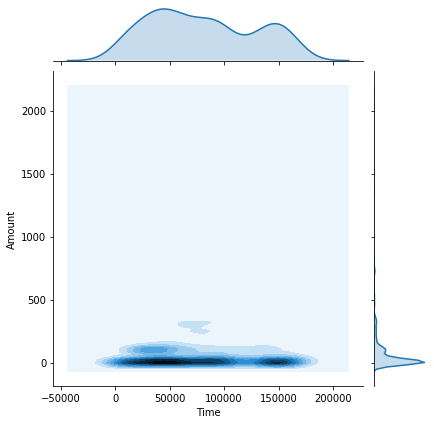

In [27]:
sns.jointplot(data[data['Class'] =='1']['Time'], data[data['Class'] =='1']['Amount'], data=data, kind="kde");

From the figure, you can see that fraudulent transaction can happen at any time, so we excluded the Time
feature for training purposes. Unlike the Time feature, the histogram of the Amount feature shows that
fraudulent transactions tend to involve relatively small amounts. Therefore, Amount could be a useful
feature for transaction classification.  However, in order to distinguish the fraudulent transactions from
normal transactions, we will still need more information from other features.

In [29]:
df = data.drop(['Time',"Class"] , axis=1)
clf = IsolationForest( behaviour = 'new', max_samples=200, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(df)
## it reports -1 as outlier and 1 as normal data

In [30]:
list(preds).count(-1)

12809

In [31]:
y_real=np.array(data["Class"].astype(int))
y_pred=np.zeros(len(preds))
for t,x in enumerate(preds):
    if x==-1: y_pred[t]=1
    else: y_pred[t]=0

In [32]:
pd.value_counts(y_pred)

0.0    271998
1.0     12809
dtype: int64

In [33]:
Error=(y_real!=y_pred).sum(dtype=float)/len(y_pred)
print("Error rate=", Error) 

Error rate= 0.04380861425456537


In [34]:
## Another approach 

In [35]:
data["Class"]=data["Class"].astype(int)
outliers = data.loc[data['Class']==1]
normal = data.loc[data['Class']==0]

outliers = outliers.drop(['Class'] , axis=1)
normal = normal.drop(['Class'] , axis=1)

X_train = np.array(normal.iloc[0:142403,:])
X_dev = np.array(normal.iloc[142403:,:])
X_test = np.array(outliers)

In [36]:
clf = IsolationForest(behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_dev = clf.predict(X_dev)
y_pred_test = clf.predict(X_test)

print("Accuracy dev :", list(y_pred_dev).count(1)/y_pred_dev.shape[0])
print("Accuracy test:", list(y_pred_test).count(-1)/y_pred_test.shape[0])

Accuracy dev : 0.8906575906195389
Accuracy test: 0.8922764227642277


## Method 5- Robust Random Cut Forest
The Robust Random Cut Forest (RRCF) algorithm is an ensemble method for detecting outliers in streaming data. RRCF offers a number of features that many competing anomaly detection algorithms lack. Specifically, RRCF:

- Is designed to handle streaming data.
- Performs well on high-dimensional data.
- Reduces the influence of irrelevant dimensions.
- Gracefully handles duplicates and near-duplicates that could otherwise mask the presence of outliers.
- Features an anomaly-scoring algorithm with a clear underlying statistical meaning.

In [41]:
#!pip install rrcf
## Currently, only Python 3 is supported.
import rrcf

### Robust random cut trees
A robust random cut tree is a binary search tree that can be used to detect outliers in a point set. Points located nearer to the root of the tree are more likely to be outliers.

#### Creating the tree

In [42]:
import numpy as np
import rrcf

# A (robust) random cut tree can be instantiated from a point set (n x d)
## creates an array of 2 columns and fills each with random values as per standard normal distribution.
X = np.random.randn(100, 2)
tree = rrcf.RCTree(X)
tree

─+
 ├───+
 │   ├───+
 │   │   ├───+
 │   │   │   ├───+
 │   │   │   │   ├───+
 │   │   │   │   │   ├──(10)
 │   │   │   │   │   └──(43)
 │   │   │   │   └───+
 │   │   │   │       ├──(35)
 │   │   │   │       └───+
 │   │   │   │           ├──(40)
 │   │   │   │           └──(55)
 │   │   │   └───+
 │   │   │       ├───+
 │   │   │       │   ├──(24)
 │   │   │       │   └──(78)
 │   │   │       └───+
 │   │   │           ├───+
 │   │   │           │   ├──(18)
 │   │   │           │   └──(88)
 │   │   │           └───+
 │   │   │               ├──(65)
 │   │   │               └──(82)
 │   │   └───+
 │   │       ├───+
 │   │       │   ├───+
 │   │       │   │   ├───+
 │   │       │   │   │   ├───+
 │   │       │   │   │   │   ├──(25)
 │   │       │   │   │   │   └───+
 │   │       │   │   │   │       ├───+
 │   │       │   │   │   │       │   ├──(27)
 │   │       │   │   │   │       │   └──(52)
 │   │       │   │   │   │       └──(90)
 │   │       │   │   │   └──(69)
 │   │       │   │  

In [43]:
print(tree.codisp(7))
print(tree.codisp(35))
print(X[7])
print(X[74])
print(X[35])

2.5
3.909090909090909
[-0.04618715 -0.37352892]
[-1.352783    1.14968148]
[-0.26194986 -1.51738017]


#### Inserting points

In [44]:
# A random cut tree can also be instantiated with no points
tree = rrcf.RCTree()
for i in range(6):
    x = np.random.randn(2)
    tree.insert_point(x, index=i)
    
tree

─+
 ├──(1)
 └───+
     ├───+
     │   ├──(0)
     │   └───+
     │       ├──(2)
     │       └───+
     │           ├──(3)
     │           └──(4)
     └──(5)

#### Deleting points

In [45]:
tree.forget_point(2)

Leaf(2)

In [46]:
print(tree)

─+
 ├──(1)
 └───+
     ├───+
     │   ├──(0)
     │   └───+
     │       ├──(3)
     │       └──(4)
     └──(5)



### Anomaly score
The likelihood that a point is an outlier is measured by its collusive displacement (CoDisp): if including a new point significantly changes the model complexity (i.e. bit depth), then that point is more likely to be an outlier.

In [47]:
# Seed tree with zero-mean, normally distributed data
X = np.random.randn(100,2)
tree = rrcf.RCTree(X)

# Generate an inlier and outlier point
inlier = np.array([0, 0])
outlier = np.array([4, 4])

# Insert into tree
tree.insert_point(inlier, index='inlier')
tree.insert_point(outlier, index='outlier')

Leaf(outlier)

In [256]:
tree.codisp('inlier')

1.1111111111111112

In [257]:
tree.codisp('outlier')

33.0

### Batch anomaly detection

In [48]:
import numpy as np
import pandas as pd
import rrcf

# Set sample parameters
np.random.seed(0)
n = 2010
d = 3

# Generate data
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)
X[0:4,]


array([[ 5.01764052e+00,  4.00157208e-03,  9.78737984e-03],
       [ 5.02240893e+00,  1.86755799e-02, -9.77277880e-03],
       [ 5.00950088e+00, -1.51357208e-03, -1.03218852e-03],
       [ 5.00410599e+00,  1.44043571e-03,  1.45427351e-02]])

In [52]:
# Set forest parameters
num_trees = 100
tree_size = 256 ## Maximum 256 data points from the dataset for each iteration 
sample_size_range = (n // tree_size, tree_size)
print(sample_size_range)

(7, 256)


In [53]:
# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                       for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

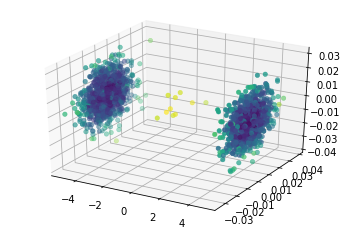

In [54]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=np.log(avg_codisp), cmap='viridis', linewidth=0.5);

In [55]:
# 99 percentile CoDisp 
qut=avg_codisp.quantile(q=0.995)

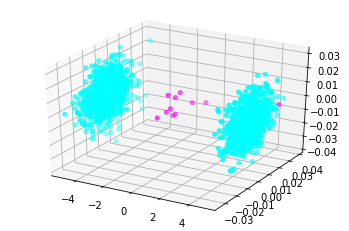

In [56]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=avg_codisp>qut, cmap='cool', linewidth=0.5);

In [ ]:
## My code: different approach

In [57]:
forest=[]
num_trees = 100*7
tree_size = 256
for num_tree in range(num_trees):
    ix = np.random.choice(n, size=tree_size,replace=False)
    trees = rrcf.RCTree(X[ix], index_labels=ix) 
    forest.append(trees)

In [58]:
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = pd.Series(0.0, index=np.arange(n))
for i in range(len(forest)):
    ## forest[tree].leaves.keys(): x points & forest[tree].leaves.values(): Leaf    
    X_p=list(forest[i].leaves.keys())
    ## calculate score
    codisp=[forest[i].codisp(x) for x in X_p]
    ## Series with both X and their scores
    My_series=pd.Series(codisp, index=X_p)
    avg_codisp[My_series.index] += codisp
    index[My_series.index]+= 1
    
for ind in index:
    if ind==0: ind=1

avg_codisp = avg_codisp/index 

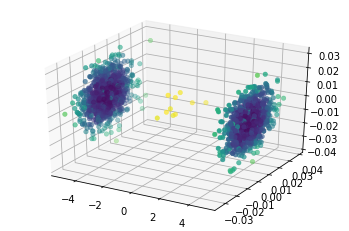

In [59]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=np.log(avg_codisp), cmap='viridis', linewidth=0.5);

### RRCF for 'creditcard.csv'

In [67]:
data = pd.read_csv('creditcard.csv')

In [68]:
df = data.drop(['Time',"Class"] , axis=1)
n=len(df)
X=np.array(df)

In [69]:
forest=[]
num_trees = n//500
tree_size = 1000
for num_tree in range(num_trees):
    ix = np.random.choice(n, size=tree_size,replace=False)
    trees = rrcf.RCTree(X[ix], index_labels=ix) 
    forest.append(trees)

In [70]:
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = pd.Series(0.0, index=np.arange(n))
for i in range(len(forest)):
    ## forest[tree].leaves.keys(): x points & forest[tree].leaves.values(): Leaf    
    X_p=list(forest[i].leaves.keys())
    ## calculate score
    codisp=[forest[i].codisp(x) for x in X_p]
    ## Series with both X and their scores
    My_series=pd.Series(codisp, index=X_p)
    avg_codisp[My_series.index] += codisp
    index[My_series.index]+= 1
    
for ind in index:
    if ind==0: ind=1

avg_codisp = avg_codisp/index 

In [71]:
avg_codisp.sort_values(ascending=False)
#index.sort_values(ascending=False)
qut=avg_codisp.quantile(q=0.99)
pred_outlier=list(avg_codisp[avg_codisp > qut].index)
Real_outlier=list(data[data["Class"]=="1"]["Class"].index)
print("No.of detected outliers: ",len(pred_outlier),"No.of real outliers: ",len(Real_outlier))

No.of detected outliers:  2462 No.of real outliers:  0


In [72]:
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    if (a_set & b_set): 
        return list(a_set & b_set) 
    else: 
        print("No common elements")  

In [73]:
print(common_member(pred_outlier,Real_outlier))

No common elements
None
